## Clip sjoin districts with original district file

In [1]:
import A1_provider_prep
import A2_other
import A3_analysis
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely.wkt
from calitp.sql import to_snakecase
from shared_utils import geography_utils, utils
from calitp.storage import get_fs
fs = get_fs()

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# Open original district
# districts = A1_provider_prep.get_districts()

### D9 T-Mobile Test

In [4]:
# Read in T-mobile file
#t_d9 = gpd.read_parquet(
#     f"{A1_provider_prep.GCS_FILE_PATH}tmobile_no_coverage_d9.parquet"
# )

In [5]:
# t_d9.plot()

In [6]:
# d9 = (districts.loc[districts.district == 9]).reset_index()

In [7]:
# d9.plot()

In [8]:
# t_d9_clipped = gpd.clip(t_d9, d9, keep_geom_type=False)

In [9]:
# t_d9_clipped.plot()

In [10]:
# 10:19 to 10:20
# routes_no_coverage = A3_analysis.comparison(
#        all_routes, t_d9_clipped
#    )

In [11]:
# routes_no_coverage.drop(columns = ["geometry"])

### Entire T-Mobile Map as a test
* Grab all the `tmobile_no_coverage...` parquet files for each district.
* Clip each of those no coverage districts against original district shapefiles.
* Stack all the clipped shapefiles above to create a map for the entire California.

In [12]:
def find_specific_files(phrase_to_find:str):
    """
    Grab a list of files that contain the 
    phrase inputted in the function.
    """
    # Create a list of all the files in my folder
    all_files_in_folder = fs.ls(A1_provider_prep.GCS_FILE_PATH)
    
    # Grab only files with the string "Verizon_no_coverage_"
    my_files = [i for i in all_files_in_folder if phrase_to_find in i]
    
    # String to add to read the Verizon only files
    my_string = "gs://"
    my_files = [my_string + i for i in my_files]
    
    return my_files

In [28]:
t_mobile_files = find_specific_files("tmobile_no_coverage_d")

In [32]:
bayarea_tmobile = ['gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_no_coverage_d1.parquet', 
                   'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_no_coverage_d3.parquet',
                   'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_no_coverage_d4.parquet',
                   'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_no_coverage_d2.parquet',]

In [34]:
def clip_no_coverage_files(phrase_to_find:str, provider:str):
    """
    Take each district file created from the 
    function `complete_difference_provider_district_level` 
    and clip the file against the original
    district shape to get rid of excess edges
    created by the `sjoin`. Join all the districts to create
    a full California map for each provider.
    """
    # Open original Caltrans districts shapefile
    # Get rid of A1_provider_prep
    districts = A1_provider_prep.get_districts()
    
    # Empty gdf to hold results
    california_gdf = pd.DataFrame()
    
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    # Loop over every file
    # Testing with just Bay Area for now 
    # Put provider_files_list later.
    for file in provider_files_list:
        # Find which district info each file contains. 
        # https://stackoverflow.com/questions/11339210/how-to-get-integer-values-from-a-string-in-python
        district_file_path = ''.join(i for i in file if i.isdigit())
        # Turn this into an integer
        district_file_path = int(district_file_path)
        # Take district_file_path and filter out district gdf
        district_of_interest = (districts.loc[districts.district == district_file_path]).reset_index()
        # Open file
        no_coverage_file = gpd.read_parquet(file)
        # Clip no coverage file against original district shape
        file_clipped = gpd.clip(no_coverage_file, district_of_interest, keep_geom_type=False)
        # Concat
        california_gdf = pd.concat([california_gdf, file_clipped], axis=0)
        print(f"Done with District {district_file_path}")
        
    # Export
    # utils.geoparquet_gcs_export(california_gdf, A1_provider_prep.GCS_FILE_PATH, f"{provider}_clipped_og_district_sjoin") 
    
    return california_gdf

In [35]:
norcal_tmobile = clip_no_coverage_files("tmobile_no_coverage_d", "tmobile")

Done with District 1
Done with District 3
Done with District 4
Done with District 2


<AxesSubplot:>

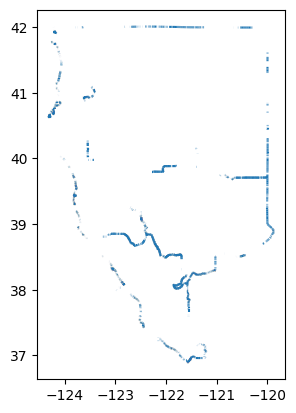

In [36]:
norcal_tmobile.plot()

In [15]:
entire_tmobile = clip_no_coverage_files("tmobile_no_coverage_d", "tmobile")

Done with District 1
Done with District 10
Done with District 11
Done with District 12
Done with District 2
Done with District 3
Done with District 4
Done with District 5
Done with District 6
Done with District 7
Done with District 8
Done with District 9


<AxesSubplot:>

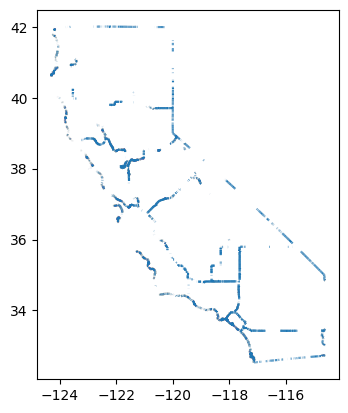

In [17]:
entire_tmobile.plot()

In [18]:
# Get routes
one_dist_routes, multi_dist_routes, all_routes = A2_other.find_multi_district_routes()

In [19]:
routes_no_coverage = A3_analysis.comparison(all_routes, entire_tmobile)

In [21]:
entire_ATT = clip_no_coverage_files("ATT_no_coverage_d", "ATT")

Done with District 1
Done with District 10
Done with District 11
Done with District 12
Done with District 2
Done with District 3
Done with District 4
Done with District 5
Done with District 6
Done with District 7
Done with District 8
Done with District 9


<AxesSubplot:>

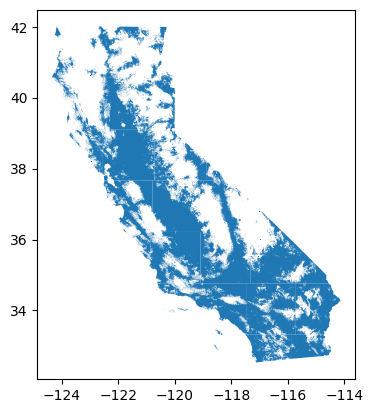

In [23]:
gpd.read_parquet("ATT.parquet").plot()

<AxesSubplot:>

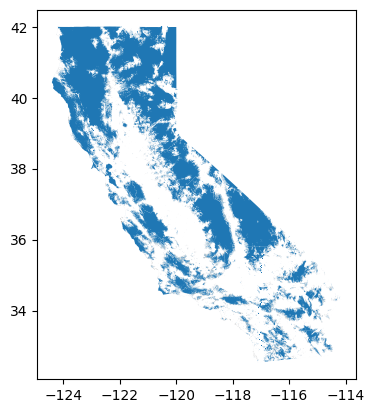

In [27]:
gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/att_all_counties.parquet").plot()

<AxesSubplot:>

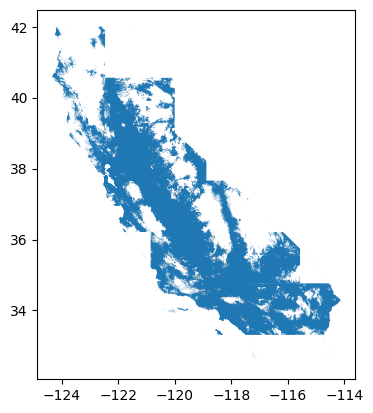

In [26]:
gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/ATT_no_coverage_complete_CA.parquet").plot()

<AxesSubplot:>

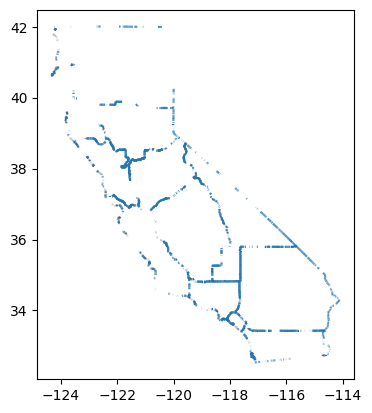

In [22]:
entire_ATT.plot()

#### Test Area

In [ ]:
# Empty gdf
tmobile_gdf = pd.DataFrame()

In [ ]:
for i in t_mobile_files:
    district_file_path = ''.join(district for district in i if district.isdigit())
    district_file_path = int(district_file_path)
    print(district_file_path)

In [ ]:
# Test file path
no_coverage_file_path = 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_no_coverage_d1.parquet'

In [ ]:
# Find which district a file belongs to 
district_file_path = ''.join(district for district in no_coverage_file_path if district.isdigit())

In [ ]:
# Turn this into an integer
district_file_path = int(district_file_path)
district_file_path

In [ ]:
# Open file path 
no_coverage_file = gpd.read_parquet(no_coverage_file_path)

In [ ]:
# Take district_file_path and filter out district gdf
district_of_interest = (districts.loc[districts.district == district_file_path]).reset_index()

In [ ]:
# Clip no coverage file against original district shape
file_clipped = gpd.clip(no_coverage_file, district_of_interest, keep_geom_type=False)

In [ ]:
file_clipped.plot()

### D4 Verizon Test
* Test district 4 for Verizon

In [24]:
# Read in Verizon D4
v_d4 = gpd.read_parquet(
   f"{A1_provider_prep.GCS_FILE_PATH}Verizon_no_coverage_d4.parquet"
 )

In [ ]:
# multi_dist_routes_dissolved.drop(columns = ["geometry"])

<AxesSubplot:>

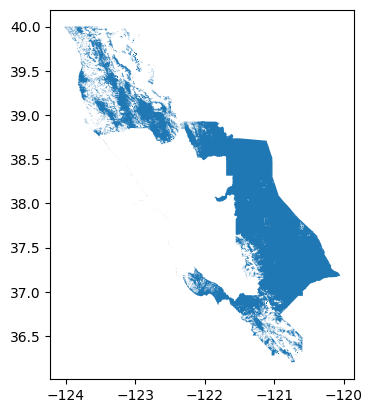

In [25]:
v_d4.plot()

In [ ]:
# Get only d4
# d4 = (districts.loc[districts.district == 4]).reset_index()

In [ ]:
# v_d4_clipped = gpd.clip(v_d4, d4, keep_geom_type=False)

In [ ]:
# v_d4_clipped.plot()

In [ ]:
"""n = v_d4_clipped.explore(
    color="red",
    width=800,
    height=400,
)"""

In [ ]:
# Clipped geometry
# n = d4.explore(m=n, legend=False)

In [ ]:
# 10:19 to 10:20
#routes_no_coverage = A2_analysis.comparison(
#        all_routes, v_d4_clipped
#    )

In [ ]:
# routes_no_coverage.drop(columns = ["geometry"])

In [ ]:
# routes_no_coverage_list = routes_no_coverage.long_route_name.unique().tolist()

In [ ]:
# routes_no_coverage_og_geo = all_routes.loc[all_routes.long_route_name.isin(routes_no_coverage_list)]

In [ ]:
# routes_no_coverage_og_geo = routes_no_coverage_og_geo.explore(width=800,
#     height=400, color= "red")

In [ ]:
# routes_no_coverage_og_geo = v_d4_clipped.explore(m=routes_no_coverage_og_geo,)

In [ ]:
# routes_no_coverage_og_geo